<a href="https://colab.research.google.com/github/sallyMo14/Prediction-of-Student-Success/blob/main/Prediction_of_Student_Success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
pip install collinearity

In [ ]:
print('heloo')

heloo


In [ ]:
pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns', None)
import seaborn as sns

# Show all rows
pd.set_option('display.max_rows', None)

# Expand display width to prevent truncation
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output='pandas')
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Custom Functions

In [ ]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None, yticks = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names

  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Set custom yticks if provided
  if yticks is not None:
      ax.set_yticks(yticks)

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [ ]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

In [ ]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [ ]:
def Visualize_clusters(df,num_cols,cat_cols,ord_cols):
  j=0
  # Visualize means
  fig, axes = plt.subplots(4,4, figsize = (20, 20))
  # fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
  axes = axes.ravel()
  # Loop over columns and plot each in a separate figure, skip 'cluster' column
  #cluster_groups.columns[1:])

  num_cluster_groups = df.groupby('cluster', as_index=False)[num_cols].mean()
  for i, col in enumerate(num_cluster_groups.columns[0:].drop(['cluster'])):
      axes[i].bar(num_cluster_groups['cluster'], num_cluster_groups[col])
      axes[i].set_title(f'Mean {col}')
      j=i+1

  ord_cluster_groups = df.groupby('cluster', as_index=False)[ord_cols].mean()
  for col in ord_cols:
      axes[j].bar(ord_cluster_groups['cluster'], ord_cluster_groups[col])
      axes[j].set_title(f'Mean {col}')
      # #Countplot: cluster on x-axis, ordinal feature as hue
      # sns.countplot(data=df, x='cluster', hue=col, ax=ax)
      # ax.set_title(f'Count {col}')
      j=j+1

  for col in cat_cols:
      sns.countplot(data=df, x='cluster',hue=col, ax=axes[j])
      axes[j].set_title(f'Count {col}')
      j=j+1


#Part One

In [ ]:
path="/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/05-IntermediateML/Week20/Data/Option_B_clustering - Option_B_clustering.csv"
df=pd.read_csv(path)
df.head()


,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,passed_course,assess_score_1,assess_score_2,assess_score_3,assess_score_4,assess_score_5
0,1,2,9,2,0,240,0,1,78,85,80,85,82
1,0,2,2,1,0,60,0,1,70,68,70,64,60
2,0,3,5,1,0,60,0,1,72,71,74,88,75
3,0,1,5,0,0,60,0,1,69,30,63,35,75
4,1,2,3,0,0,60,0,1,70,65,62,75,68


##Explore the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12737 entries, 0 to 12736
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   gender                12737 non-null  int64
 1   highest_education     12737 non-null  int64
 2   imd_band              12737 non-null  int64
 3   age_band              12737 non-null  int64
 4   num_of_prev_attempts  12737 non-null  int64
 5   studied_credits       12737 non-null  int64
 6   disability            12737 non-null  int64
 7   passed_course         12737 non-null  int64
 8   assess_score_1        12737 non-null  int64
 9   assess_score_2        12737 non-null  int64
 10  assess_score_3        12737 non-null  int64
 11  assess_score_4        12737 non-null  int64
 12  assess_score_5        12737 non-null  int64
dtypes: int64(13)
memory usage: 1.3 MB


###Check for null values \ duplicates

In [ ]:
df.isna().sum()

,0
gender,0
highest_education,0
imd_band,0
age_band,0
num_of_prev_attempts,0
studied_credits,0
disability,0
passed_course,0
assess_score_1,0
assess_score_2,0


* No null values

In [ ]:
df.duplicated().sum()

np.int64(7)

* drop duplicates

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(0)

###Explore data distribution

####Gender

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


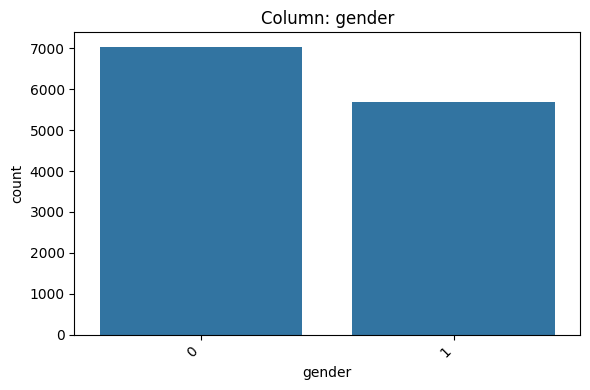

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 7042 times (55.32%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: gender'}, xlabel='gender', ylabel='count'>)

In [ ]:
explore_categorical(df,'gender')

* Gender 0,1 are not defined
* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ctegorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

####highest_education

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


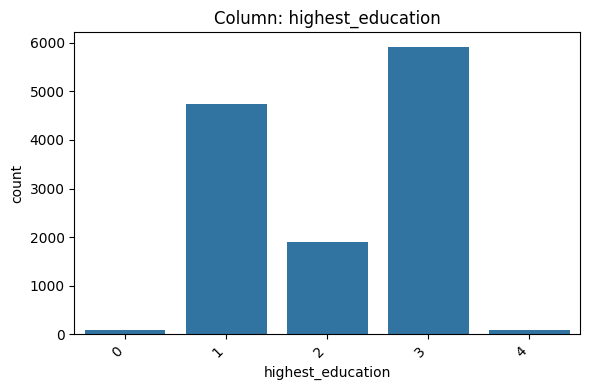

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: '3' occurs 5916 times (46.47%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: highest_education'}, xlabel='highest_education', ylabel='count'>)

In [ ]:
explore_categorical(df,'highest_education')

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ordinal
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

####imd_band

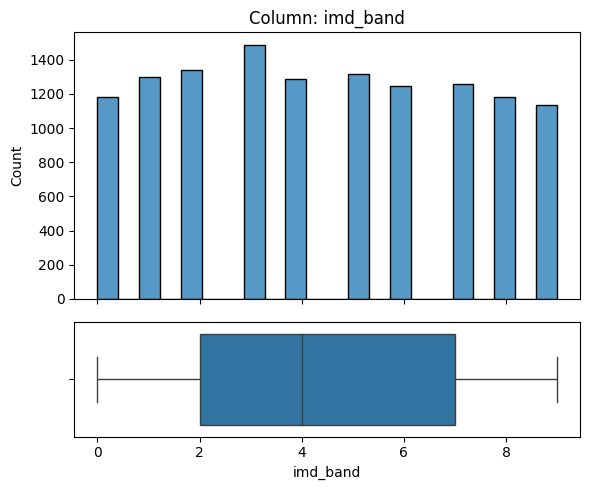

- NaN's Found: 0 (0.0%)


In [ ]:
# order=df['imd_band'].mean().sort_values().index
explore_numeric(df,'imd_band')

* most records have imb_band between (2,6)

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ordinal
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

####age_band

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


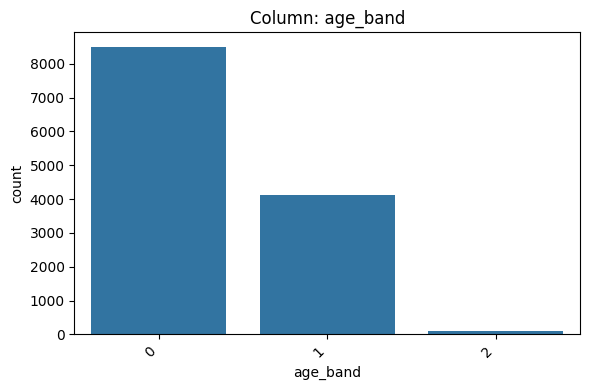

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: '0' occurs 8507 times (66.83%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: age_band'}, xlabel='age_band', ylabel='count'>)

In [ ]:
explore_categorical(df,'age_band')

* most recors belongs to age_band=0 (more than 8500)
* least records belongs to age_band=2 (around 200)

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Ordinal
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

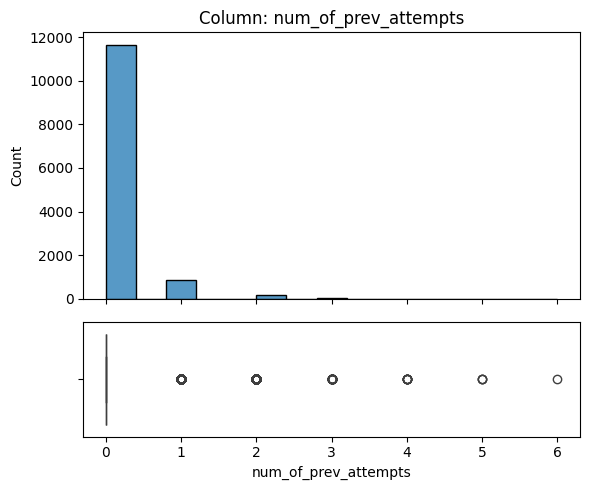

- NaN's Found: 0 (0.0%)


In [ ]:
explore_numeric(df,'num_of_prev_attempts')

####num_of_prev_attempts

* most records have 0 prev attempts (almost 11800)
* almost 1000 student have just one previous attempt
* and very few records are destributed betwwen (2,3,4,5,6)


* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Numerical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

####studied_credits

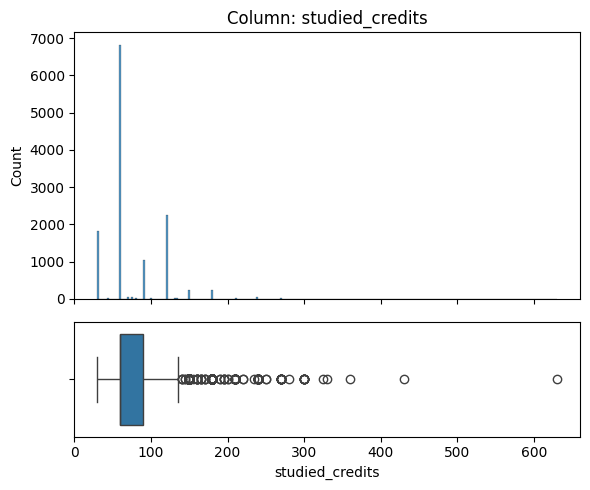

- NaN's Found: 0 (0.0%)


In [ ]:
explore_numeric(df,'studied_credits')

* most students have finished between 70-90 credits
* there are some outliers 150-630 credits
* most data are distributed between 40 -120

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Numerical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

####disability

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


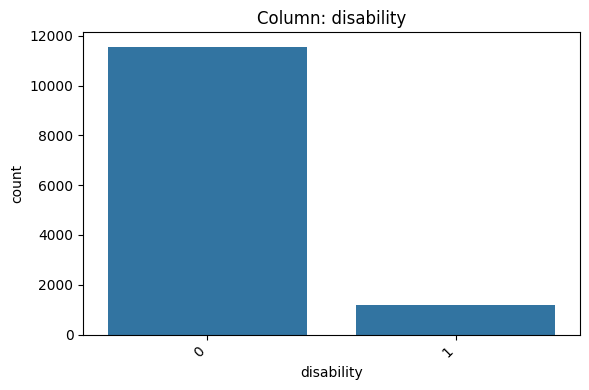

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 11560 times (90.81%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: disability'}, xlabel='disability', ylabel='count'>)

In [ ]:
explore_categorical(df,'disability')

* there is a small percent of the students have disability (9.19%)

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Categorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

####passed_course

/tmp/ipython-input-2460091364.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


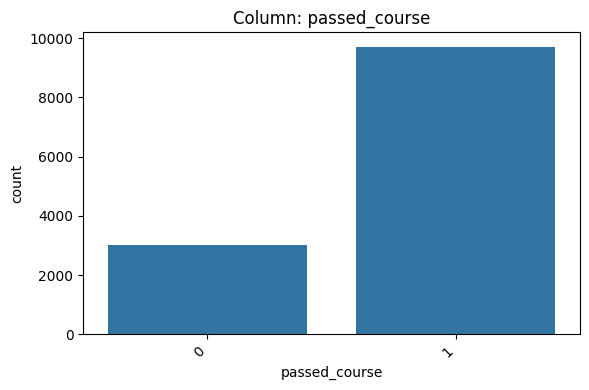

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1' occurs 9713 times (76.3%)
- Not constant or quasi-constant.


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Column: passed_course'}, xlabel='passed_course', ylabel='count'>)

In [ ]:
explore_categorical(df,'passed_course')

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
  * Categorical
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  * No null values
* Is the feature constant or quasi-constant?
  * No
* What is the cardinality? Is it high?
  * No
* Would we know this BEFORE the target is determined?
  * Yes
* Is there a business case/understanding reason to exclude based on our business case?
  * No

##clustering

In [ ]:
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df)
df_scaled.describe()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,passed_course,assess_score_1,assess_score_2,assess_score_3,assess_score_4,assess_score_5
count,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04,1.273000e+04
mean,3.572249e-17,4.465312e-17,3.572249e-17,-5.358374e-17,5.581640e-17,1.786125e-17,-4.576945e-17,1.160981e-16,-1.428900e-16,3.840168e-16,-3.572249e-17,3.572249e-17,1.786125e-16
std,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00
min,-8.987353e-01,-2.221398e+00,-1.570438e+00,-6.937344e-01,-2.756338e-01,-1.195309e+00,-3.181369e-01,-1.794275e+00,-3.860392e+00,-5.112432e+00,-4.516797e+00,-4.211108e+00,-3.999458e+00
25%,-8.987353e-01,-1.158580e+00,-8.577476e-01,-6.937344e-01,-2.756338e-01,-3.944097e-01,-3.181369e-01,5.573281e-01,-4.167474e-01,-6.084017e-01,-6.080791e-01,-5.934047e-01,-5.686940e-01
50%,-8.987353e-01,-9.576216e-02,-1.450574e-01,-6.937344e-01,-2.756338e-01,-3.944097e-01,-3.181369e-01,5.573281e-01,1.571933e-01,7.402718e-02,7.169787e-02,1.857928e-01,9.697657e-02
75%,1.112675e+00,9.670559e-01,9.239779e-01,1.351481e+00,-2.756338e-01,4.064892e-01,-3.181369e-01,5.573281e-01,6.267811e-01,7.564561e-01,8.647710e-01,7.423625e-01,9.162635e-01
max,1.112675e+00,2.029874e+00,1.636668e+00,3.396696e+00,1.511392e+01,1.482267e+01,3.143301e+00,5.573281e-01,1.357251e+00,1.711857e+00,1.148011e+00,1.354589e+00,1.121085e+00


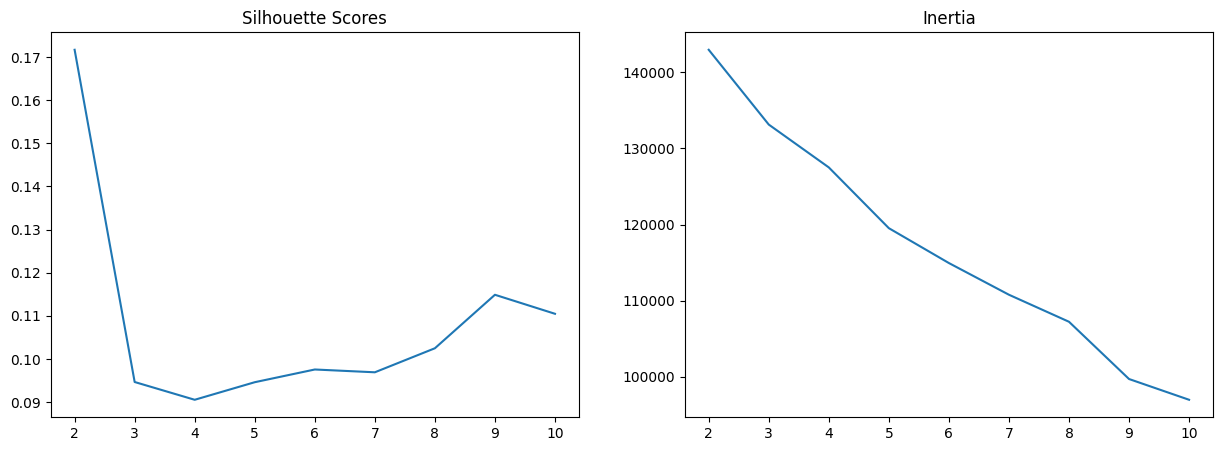

In [ ]:
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(df_scaled)
  sils.append(silhouette_score(df_scaled, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

* There is an elbow at 5 clusters

##### **5 clusters**

In [ ]:
clusters=5
kmeans = KMeans(n_clusters=clusters, n_init = 'auto', random_state=42)
kmeans.fit(df_scaled)

KMeans(n_clusters=5, random_state=42)

In [ ]:
df['cluster'] = kmeans.labels_
df.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,passed_course,assess_score_1,assess_score_2,assess_score_3,assess_score_4,assess_score_5,cluster
0,1,2,9,2,0,240,0,1,78,85,80,85,82,0
1,0,2,2,1,0,60,0,1,70,68,70,64,60,1
2,0,3,5,1,0,60,0,1,72,71,74,88,75,4
3,0,1,5,0,0,60,0,1,69,30,63,35,75,3
4,1,2,3,0,0,60,0,1,70,65,62,75,68,0


In [ ]:
cat_cols=['gender','disability','passed_course']
ord_cols=['highest_education',	'imd_band',	'age_band']
num_cols=df.columns.drop(cat_cols+ord_cols)
num_cols

Index(['num_of_prev_attempts', 'studied_credits', 'assess_score_1',
       'assess_score_2', 'assess_score_3', 'assess_score_4', 'assess_score_5',
       'cluster'],
      dtype='object')

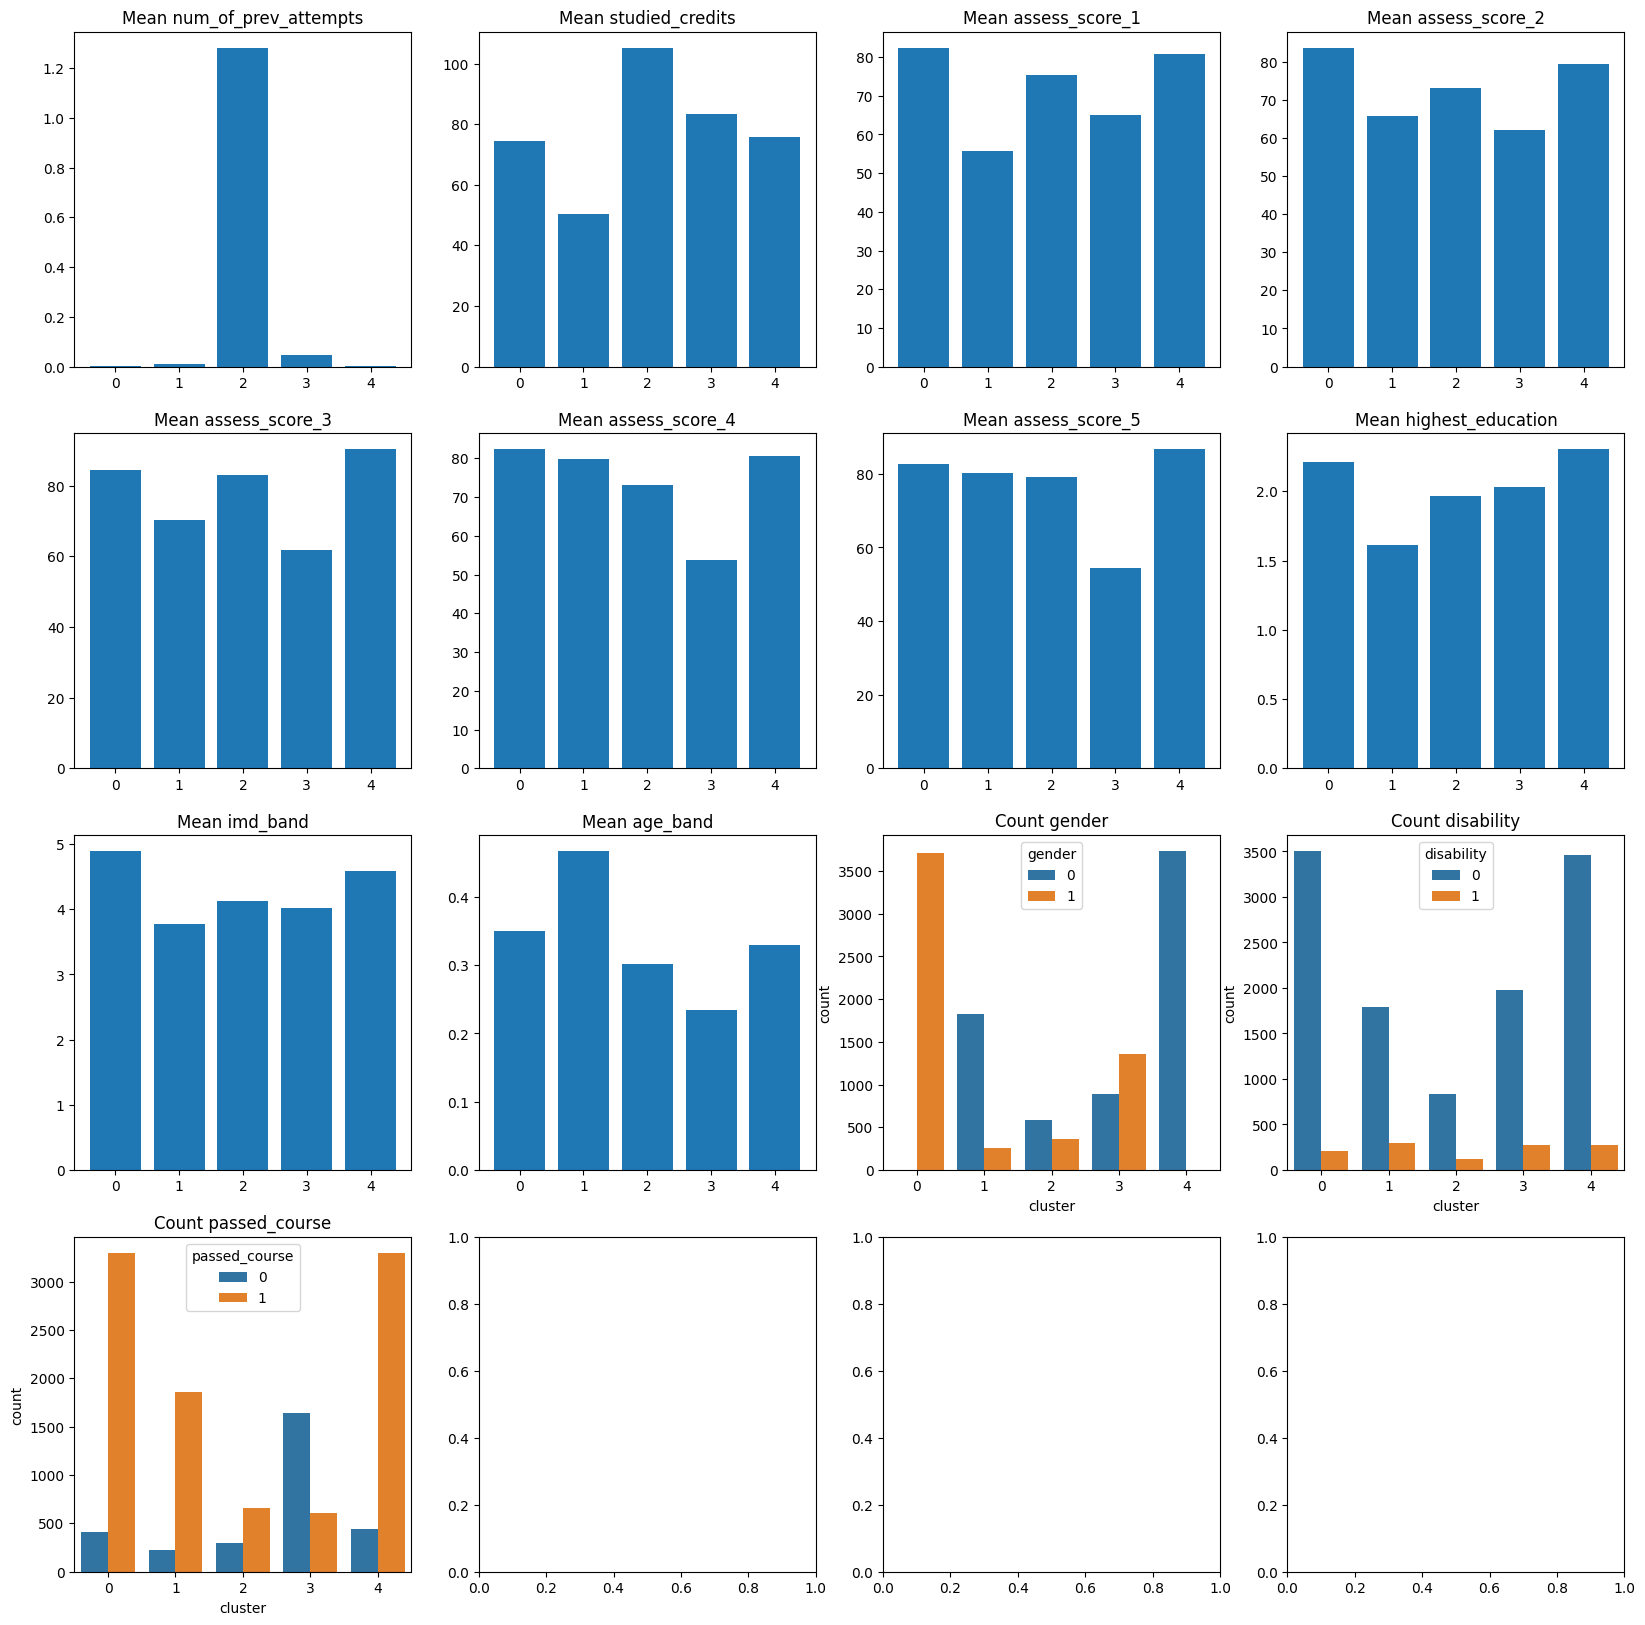

In [ ]:
Visualize_clusters(df=df,num_cols=num_cols,cat_cols=cat_cols,ord_cols=ord_cols)

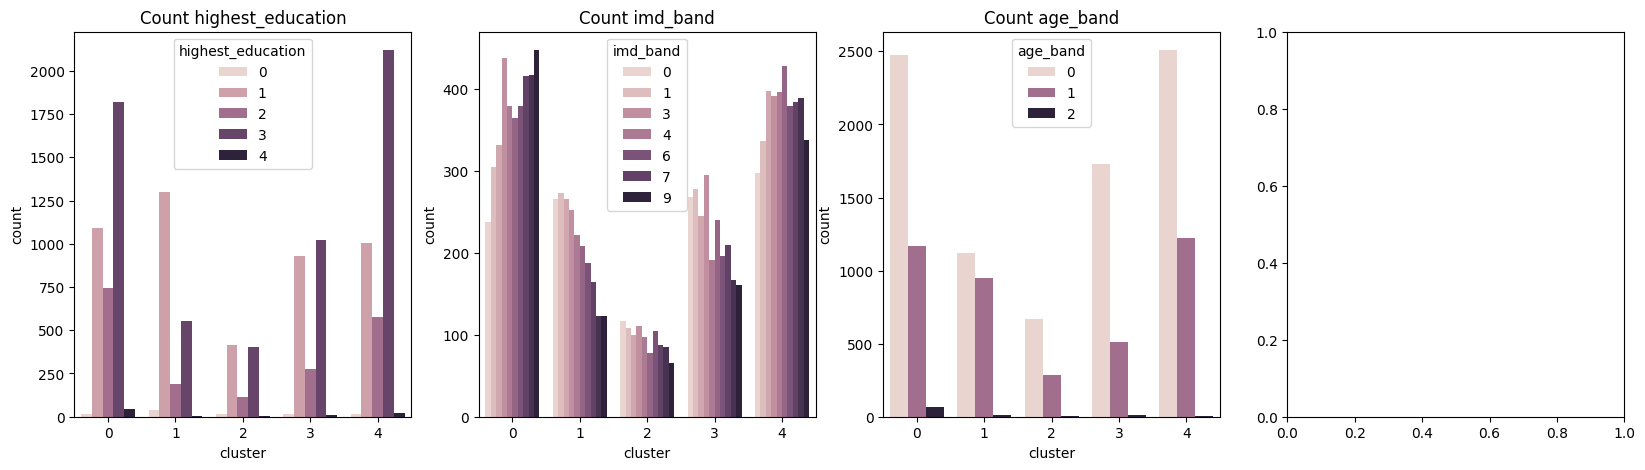

In [ ]:
fig, axes = plt.subplots(1,4, figsize = (20, 5))
i=0
for col in ord_cols:
  #Countplot: cluster on x-axis, ordinal feature as hue
      sns.countplot(data=df, x='cluster', hue=col, ax=axes[i])
      axes[i].set_title(f'Count {col}')
      i=i+1

* I made a condition on the column type , in order to drow the right plot according to the type(numerival -> mean , categorical -> count)
* According to the plots above , there are some clusters with similler distributions (0,4) , so i will use 4clusters and see

##### 4 clusters

In [ ]:
clusters=4
kmeans = KMeans(n_clusters=clusters, n_init = 'auto', random_state=42)
kmeans.fit(df_scaled)


KMeans(n_clusters=4, random_state=42)

In [ ]:
df['cluster'] = kmeans.labels_
df.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,passed_course,assess_score_1,assess_score_2,assess_score_3,assess_score_4,assess_score_5,cluster
0,1,2,9,2,0,240,0,1,78,85,80,85,82,0
1,0,2,2,1,0,60,0,1,70,68,70,64,60,1
2,0,3,5,1,0,60,0,1,72,71,74,88,75,2
3,0,1,5,0,0,60,0,1,69,30,63,35,75,3
4,1,2,3,0,0,60,0,1,70,65,62,75,68,1


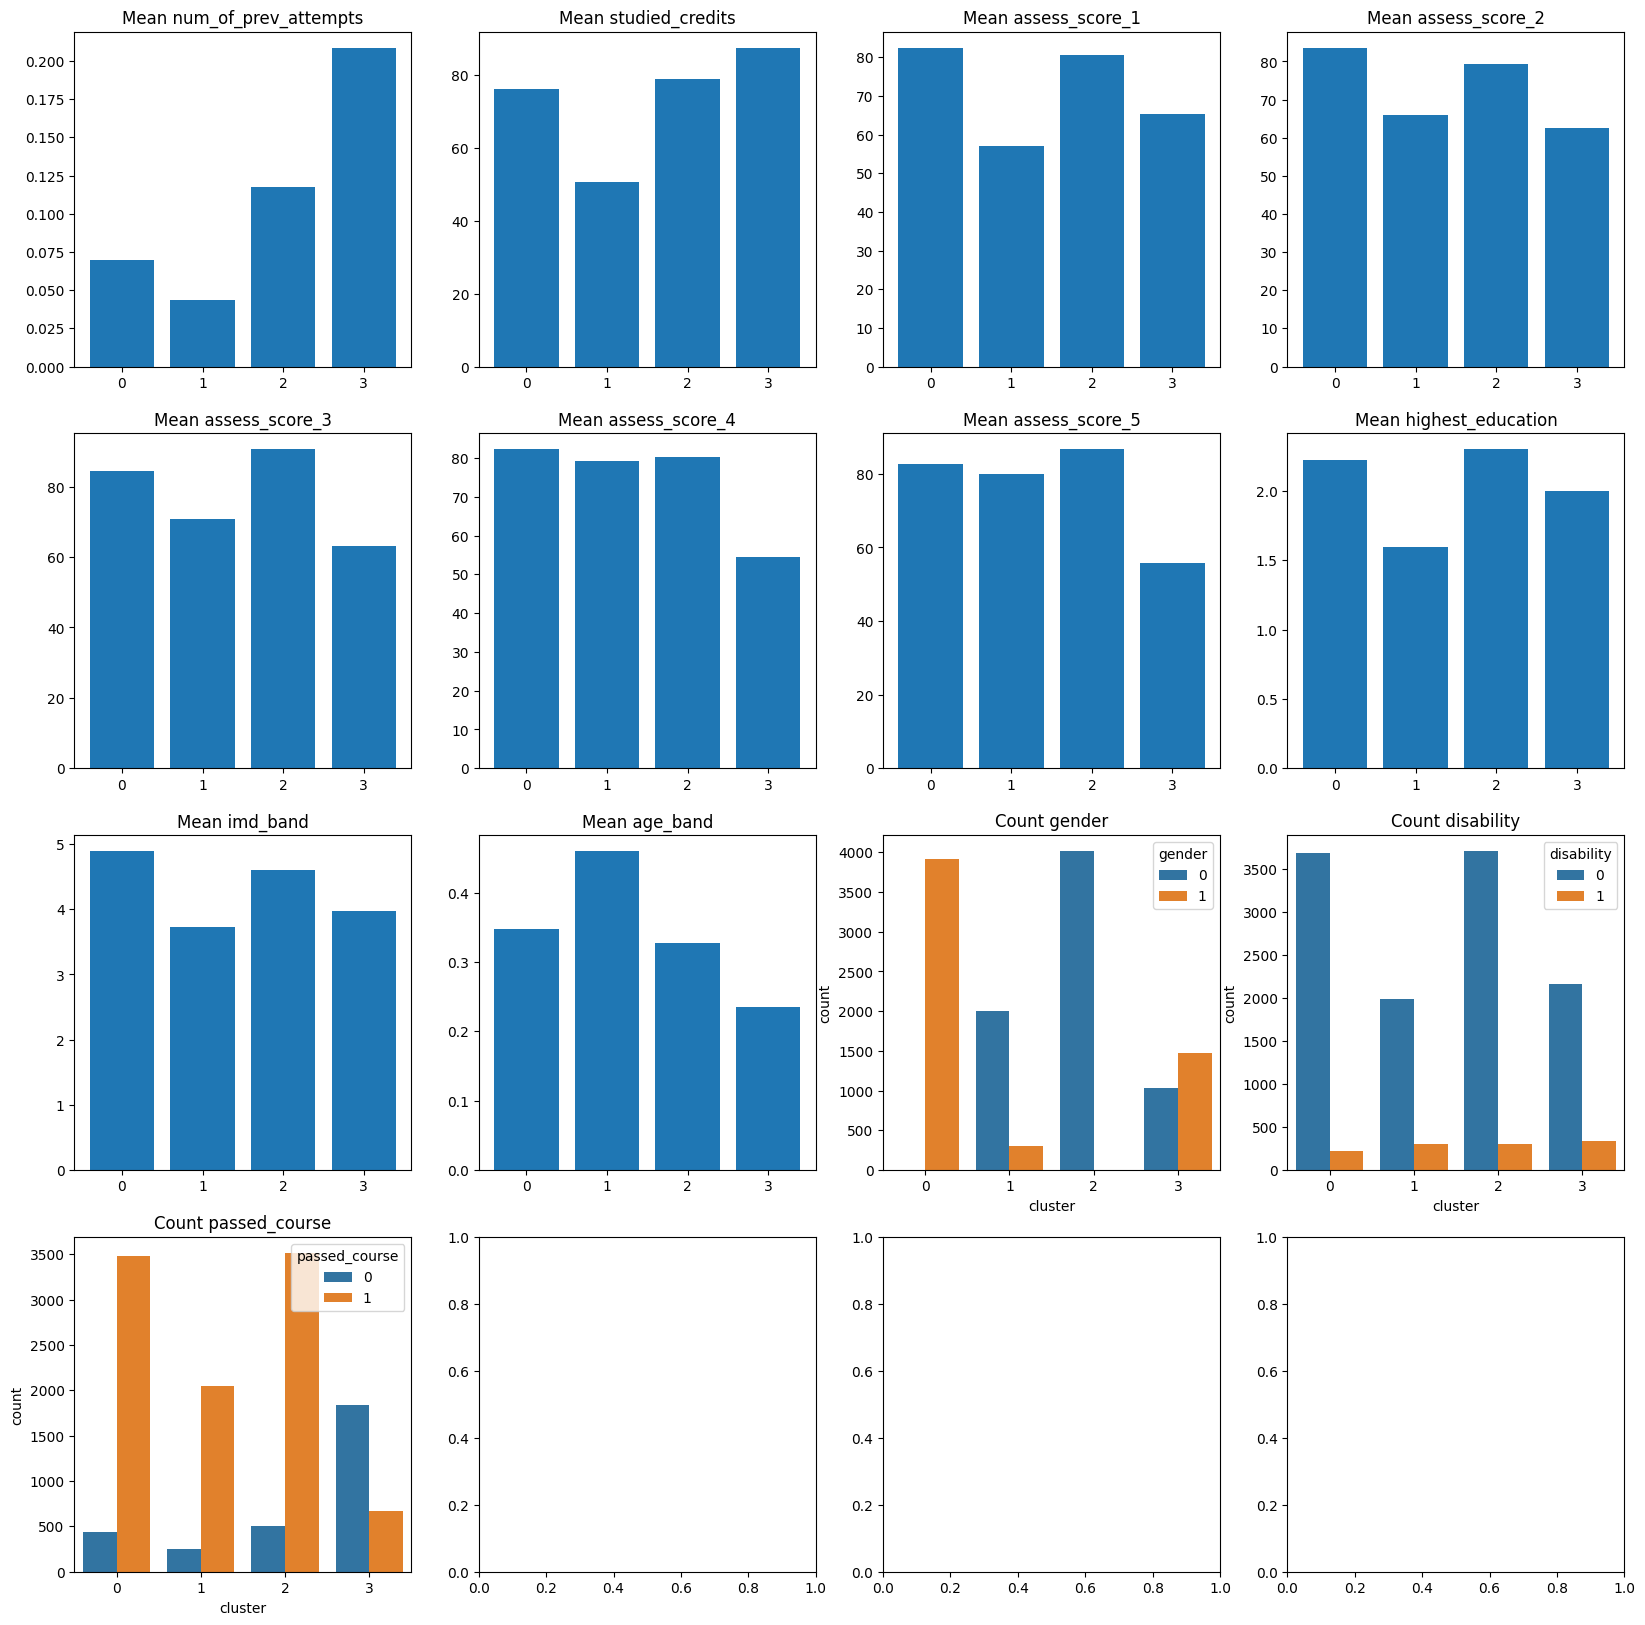

In [ ]:
Visualize_clusters(df=df,num_cols=num_cols,cat_cols=cat_cols,ord_cols=ord_cols)

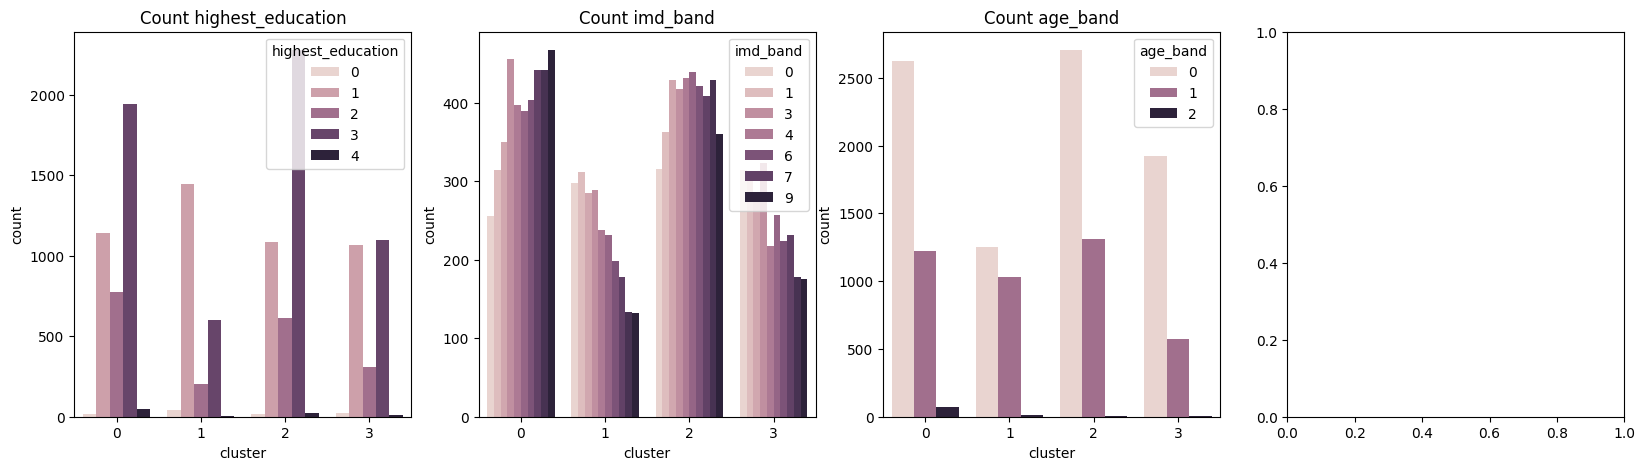

In [ ]:
fig, axes = plt.subplots(1,4, figsize = (20, 5))
i=0
for col in ord_cols:
  #Countplot: cluster on x-axis, ordinal feature as hue
      sns.countplot(data=df, x='cluster', hue=col, ax=axes[i])
      axes[i].set_title(f'Count {col}')
      i=i+1

* Still there are similler clusters so i will use 3 clusters

##### **3 Clusters**

In [ ]:
clusters=3
kmeans = KMeans(n_clusters=clusters, n_init = 'auto', random_state=42)
kmeans.fit(df_scaled)
df['cluster'] = kmeans.labels_
df.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,passed_course,assess_score_1,assess_score_2,assess_score_3,assess_score_4,assess_score_5,cluster
0,1,2,9,2,0,240,0,1,78,85,80,85,82,0
1,0,2,2,1,0,60,0,1,70,68,70,64,60,2
2,0,3,5,1,0,60,0,1,72,71,74,88,75,2
3,0,1,5,0,0,60,0,1,69,30,63,35,75,1
4,1,2,3,0,0,60,0,1,70,65,62,75,68,0


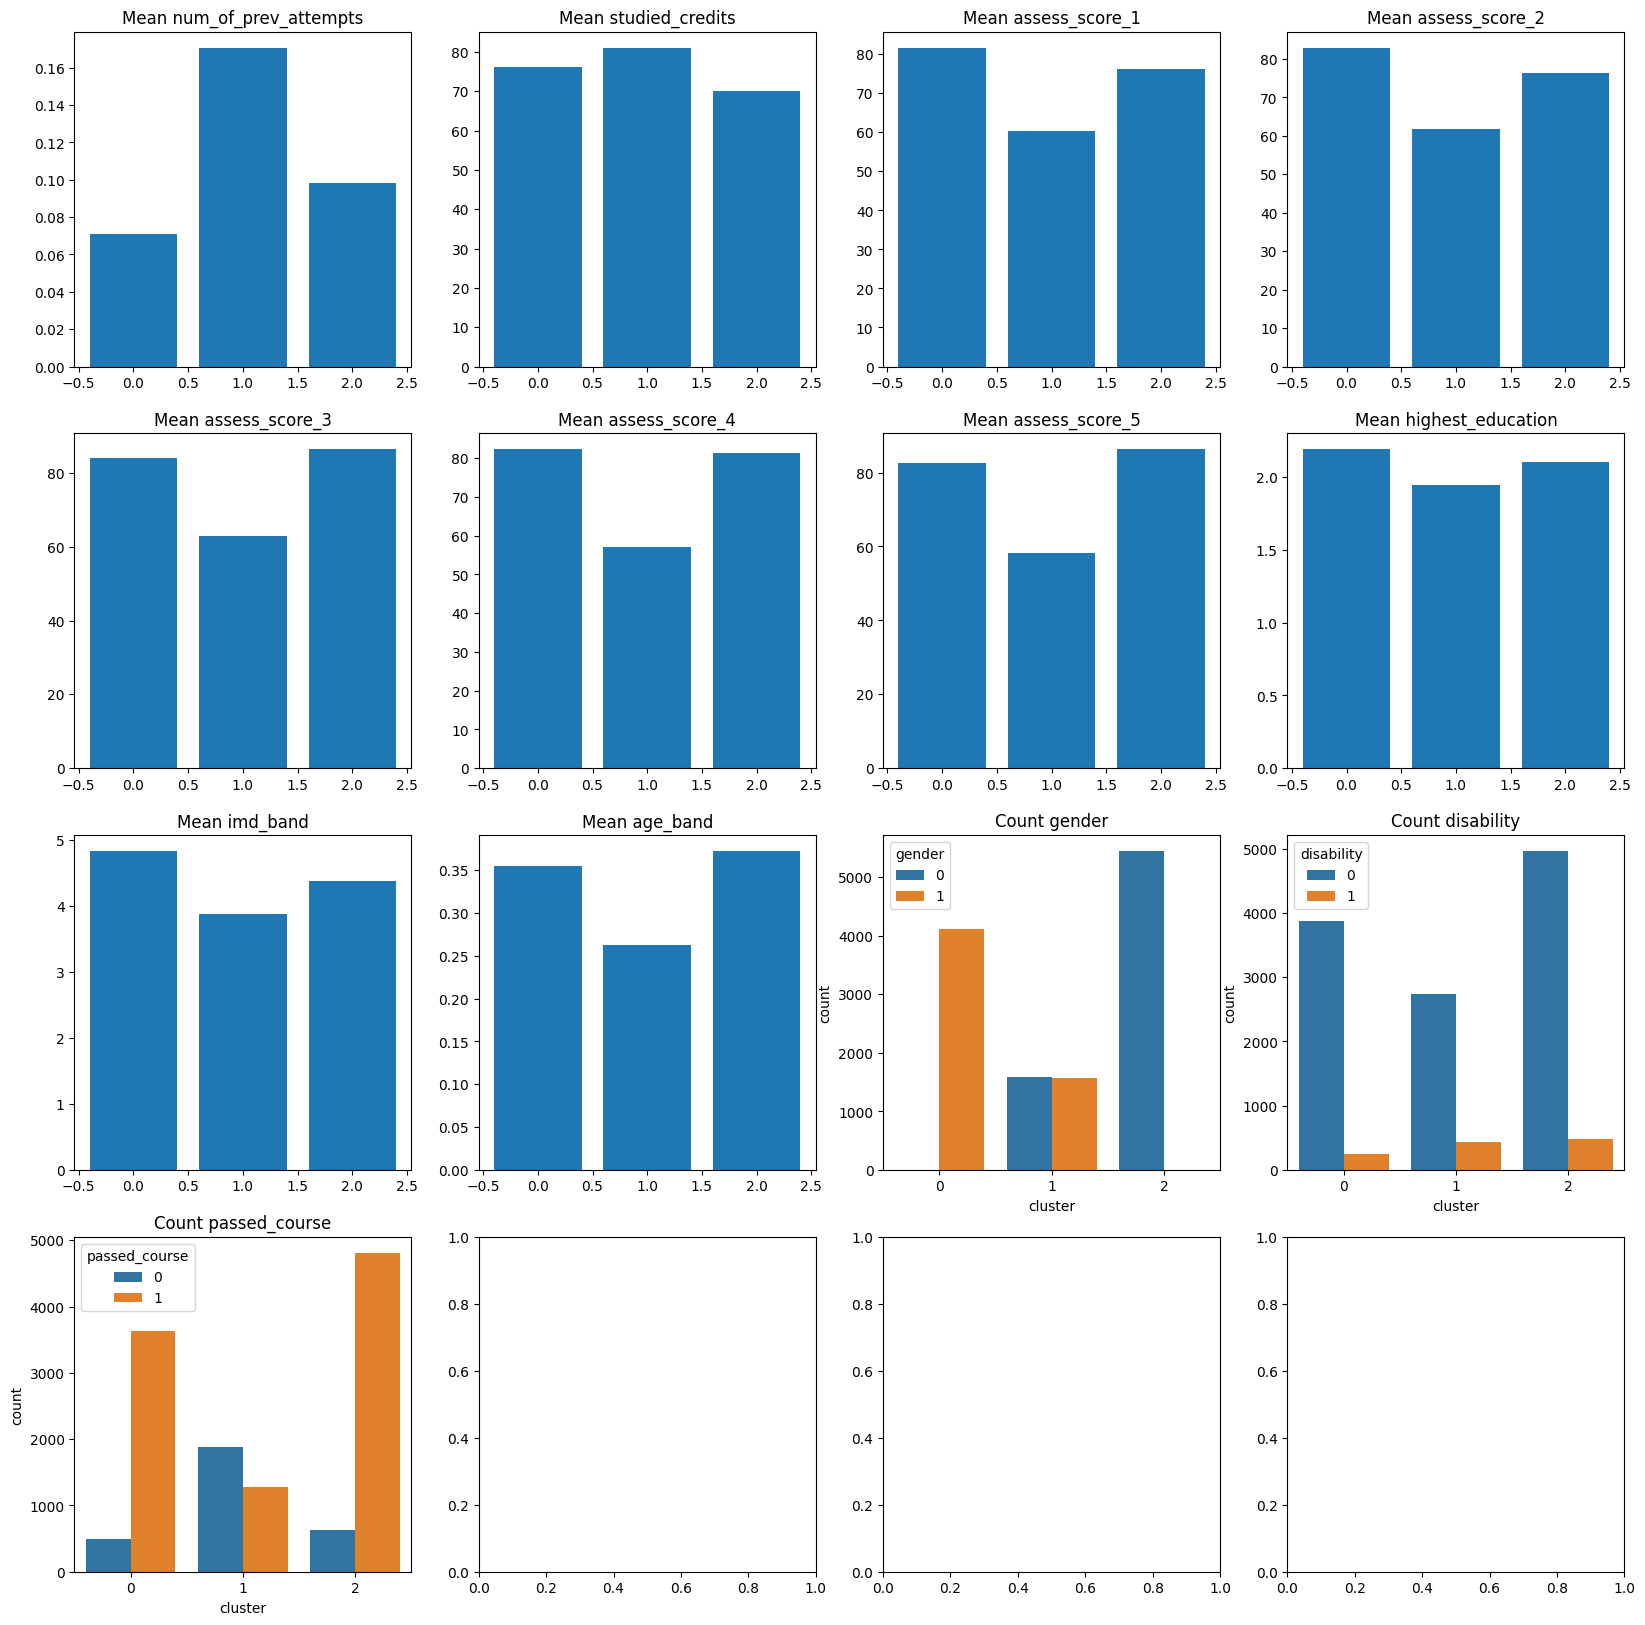

In [ ]:
Visualize_clusters(df=df,num_cols=num_cols,cat_cols=cat_cols,ord_cols=ord_cols)


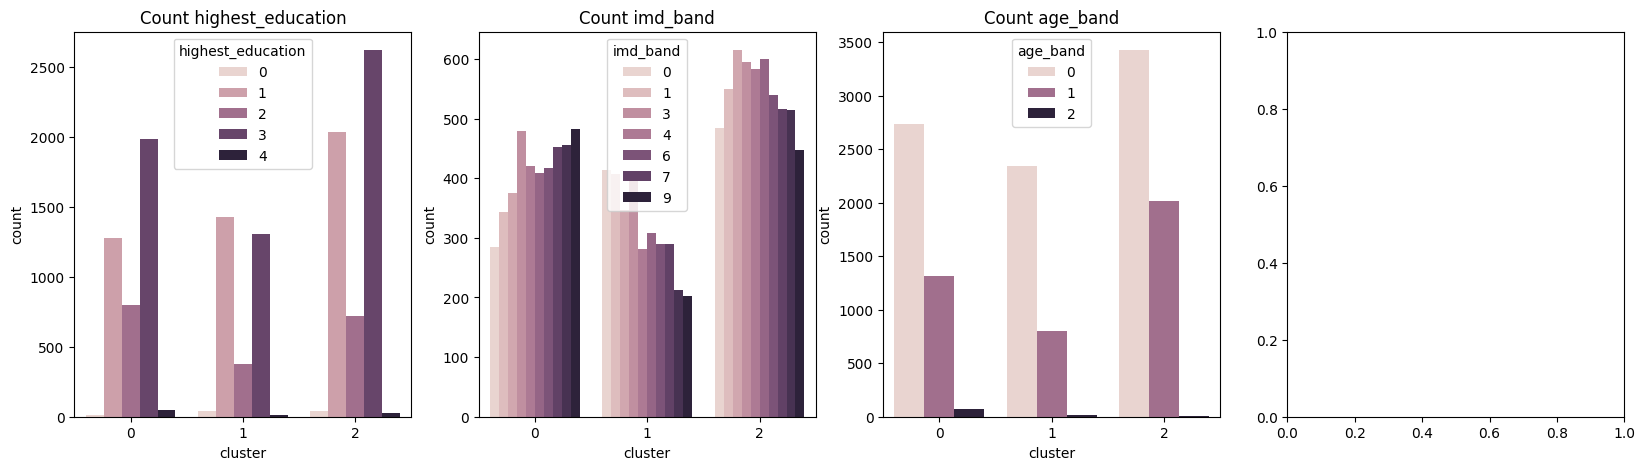

In [ ]:
fig, axes = plt.subplots(1,4, figsize = (20, 5))
i=0
for col in ord_cols:
  #Countplot: cluster on x-axis, ordinal feature as hue
      sns.countplot(data=df, x='cluster', hue=col, ax=axes[i])
      axes[i].set_title(f'Count {col}')
      i=i+1

* I think cluster 0,2 are very close

#####2 clusters

In [ ]:
clusters=2
kmeans = KMeans(n_clusters=clusters, n_init = 'auto', random_state=42)
kmeans.fit(df_scaled)
df['cluster'] = kmeans.labels_
df.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,passed_course,assess_score_1,assess_score_2,assess_score_3,assess_score_4,assess_score_5,cluster
0,1,2,9,2,0,240,0,1,78,85,80,85,82,0
1,0,2,2,1,0,60,0,1,70,68,70,64,60,1
2,0,3,5,1,0,60,0,1,72,71,74,88,75,0
3,0,1,5,0,0,60,0,1,69,30,63,35,75,1
4,1,2,3,0,0,60,0,1,70,65,62,75,68,1


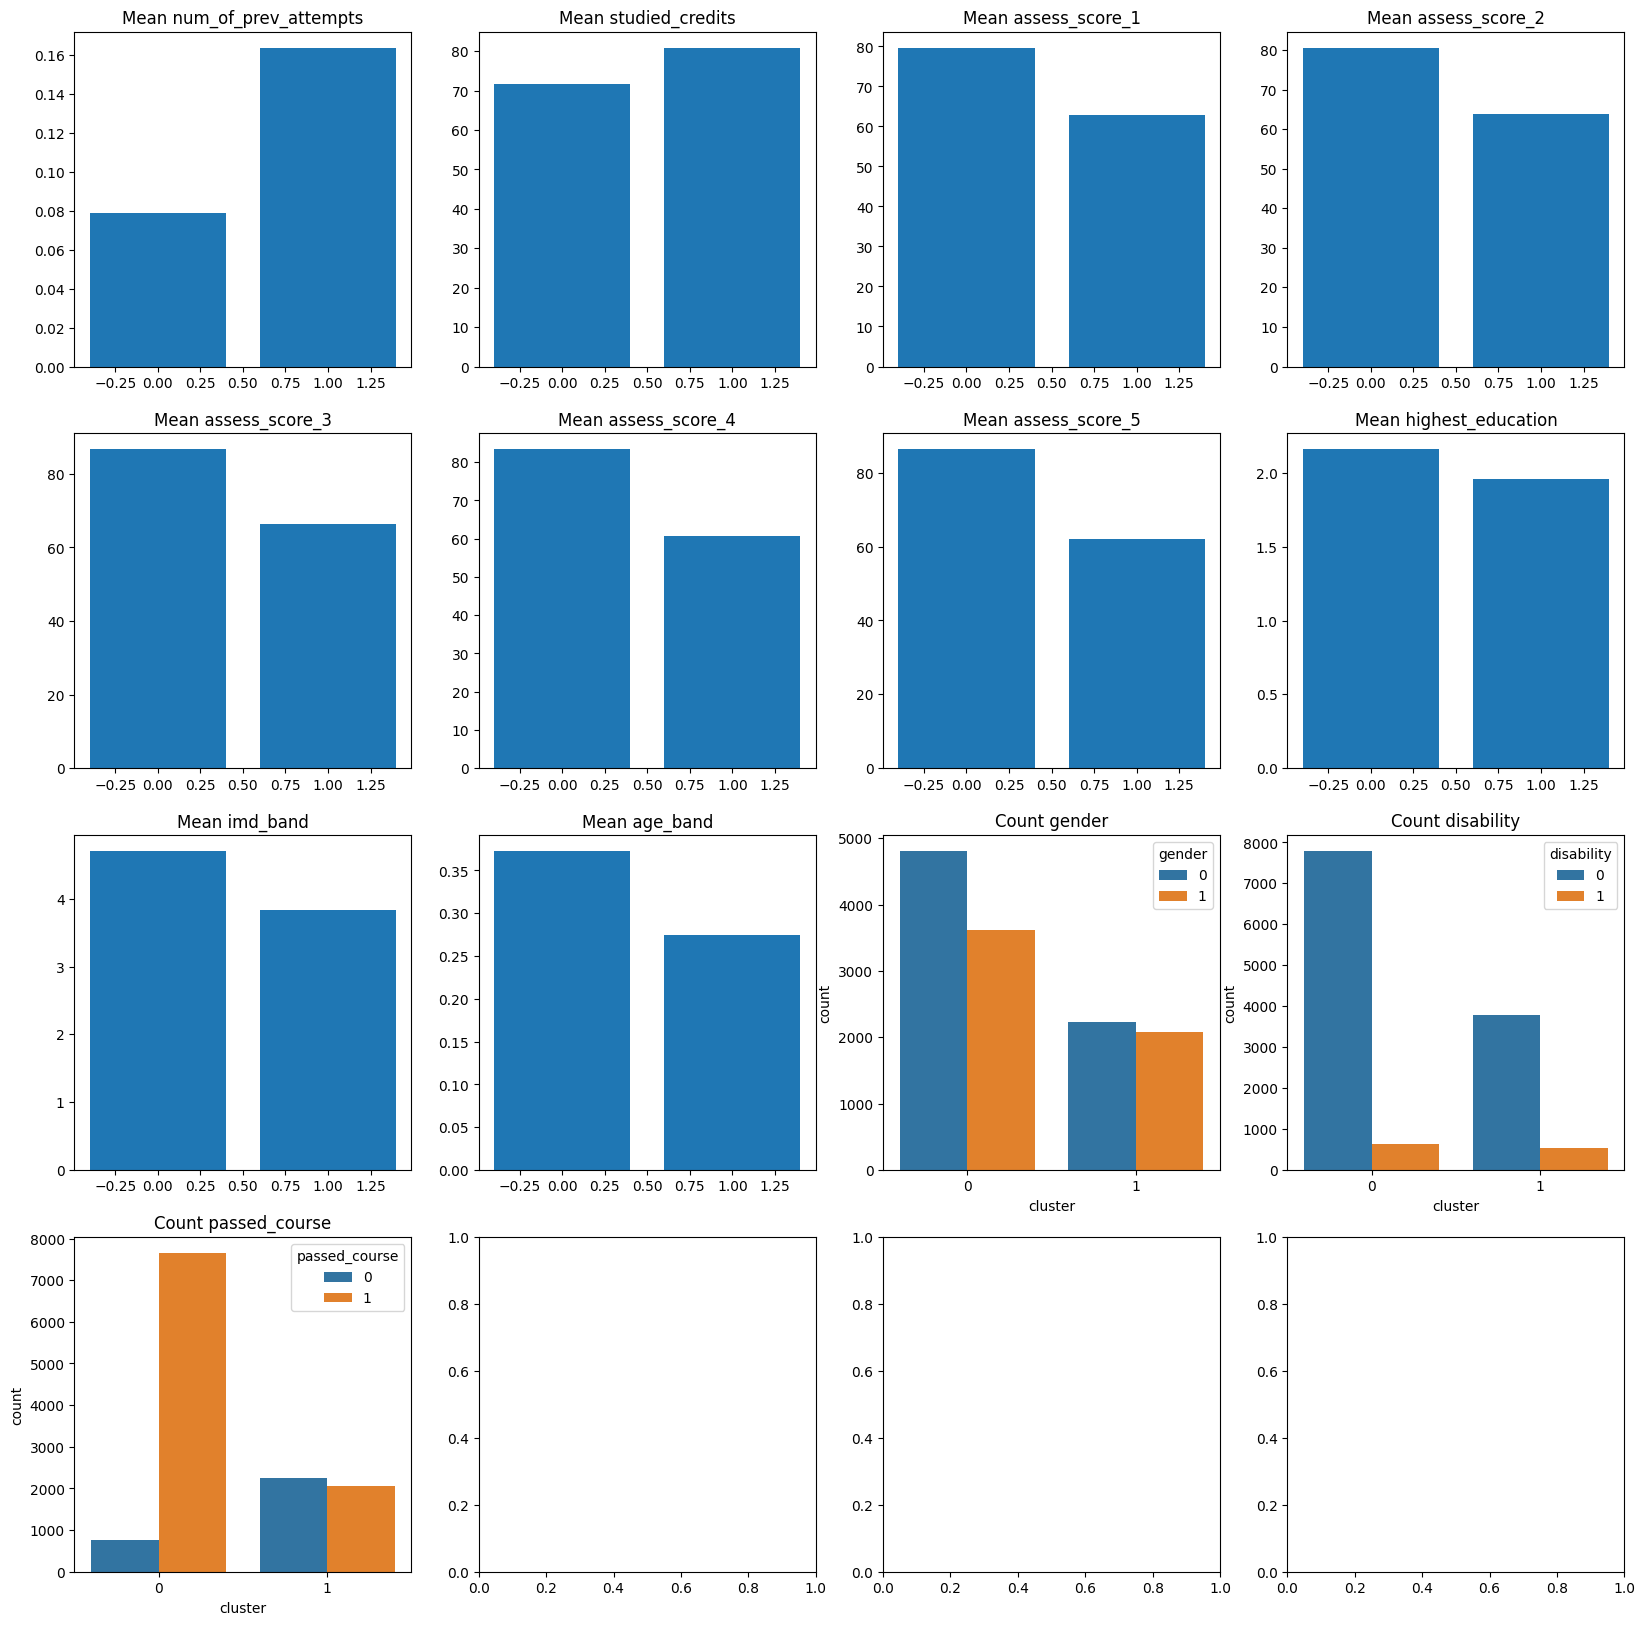

In [ ]:
Visualize_clusters(df=df,num_cols=num_cols,cat_cols=cat_cols,ord_cols=ord_cols)

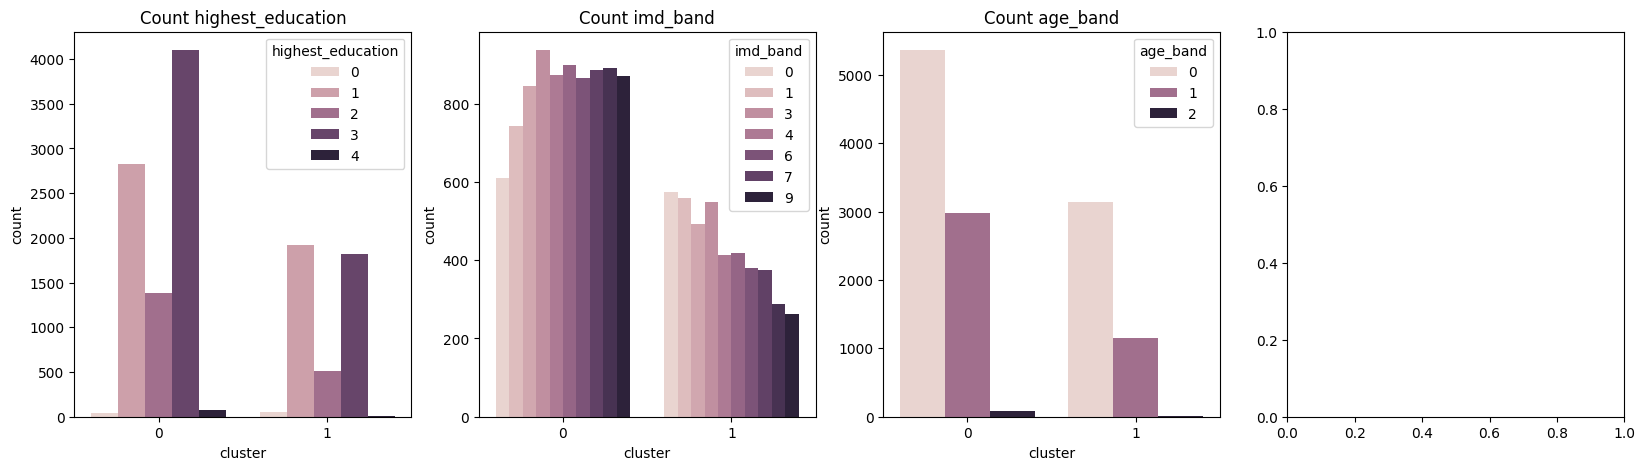

In [ ]:
fig, axes = plt.subplots(1,4, figsize = (20, 5))
i=0
for col in ord_cols:
  #Countplot: cluster on x-axis, ordinal feature as hue
      sns.countplot(data=df, x='cluster', hue=col, ax=axes[i])
      axes[i].set_title(f'Count {col}')
      i=i+1

* cluster 0 :    
  * have  leess mean of  number of brevious attempts
  * have the highest studied_credits mean ( higher values reflect academic experience )
  * have the highest assess score 1,2,3,4,5
  * have the highest imb band mean (less deprivation)
  * have the highest age band mean (older)
  * the mojority of this cluster have passed course


* cluster 1:
  * have higher mean of number of previous attempts (Higher values indicate struggling students)
  * have less studied_credit means
  * have less assess score 1,2,3,4,5
  * have less imb band mean
  * have less age band mean
  * the majority of this cluster havent passed the course

#Part Two

In [ ]:
path="/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/05-IntermediateML/Week20/Data/Option_B_modeling.csv"
df=pd.read_csv(path)
df.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,passed_course,assess_score_1,assess_score_2,assess_score_3,assess_score_4,assess_score_5,assess_submitted_1,assess_submitted_2,assess_submitted_3,assess_submitted_4,assess_submitted_5,assess_submitted_6,assess_score_6,assess_submitted_7,assess_score_7,assess_submitted_8,assess_score_8,assess_submitted_9,assess_score_9,assess_submitted_10,assess_score_10,assess_submitted_11,assess_score_11,assess_submitted_12,assess_score_12,assess_submitted_13,assess_score_13,assess_submitted_14,assess_score_14,sum_activities_-25,sum_click_-25,activities_x_clicks_-25,sum_activities_-24,sum_click_-24,activities_x_clicks_-24,sum_activities_-23,sum_click_-23,activities_x_clicks_-23,sum_activities_-22,sum_click_-22,activities_x_clicks_-22,sum_activities_-21,sum_click_-21,activities_x_clicks_-21,sum_activities_-20,sum_click_-20,activities_x_clicks_-20,sum_activities_-19,sum_click_-19,activities_x_clicks_-19,sum_activities_-18,sum_click_-18,activities_x_clicks_-18,sum_activities_-17,sum_click_-17,activities_x_clicks_-17,sum_activities_-16,sum_click_-16,activities_x_clicks_-16,sum_activities_-15,sum_click_-15,activities_x_clicks_-15,sum_activities_-14,sum_click_-14,activities_x_clicks_-14,sum_activities_-13,sum_click_-13,activities_x_clicks_-13,sum_activities_-12,sum_click_-12,activities_x_clicks_-12,sum_activities_-11,sum_click_-11,activities_x_clicks_-11,sum_activities_-10,sum_click_-10,activities_x_clicks_-10,sum_activities_-9,sum_click_-9,activities_x_clicks_-9,sum_activities_-8,sum_click_-8,activities_x_clicks_-8,sum_activities_-7,sum_click_-7,activities_x_clicks_-7,sum_activities_-6,sum_click_-6,activities_x_clicks_-6,sum_activities_-5,sum_click_-5,activities_x_clicks_-5,sum_activities_-4,sum_click_-4,activities_x_clicks_-4,sum_activities_-3,sum_click_-3,activities_x_clicks_-3,sum_activities_-2,sum_click_-2,activities_x_clicks_-2,sum_activities_-1,sum_click_-1,activities_x_clicks_-1,sum_activities_0,sum_click_0,activities_x_clicks_0,sum_activities_1,sum_click_1,activities_x_clicks_1,sum_activities_2,sum_click_2,activities_x_clicks_2,sum_activities_3,sum_click_3,activities_x_clicks_3,sum_activities_4,sum_click_4,activities_x_clicks_4,sum_activities_5,sum_click_5,activities_x_clicks_5,sum_activities_6,sum_click_6,activities_x_clicks_6,sum_activities_7,sum_click_7,activities_x_clicks_7,sum_activities_8,sum_click_8,activities_x_clicks_8,sum_activities_9,sum_click_9,activities_x_clicks_9,sum_activities_10,sum_click_10,activities_x_clicks_10,sum_activities_11,sum_click_11,activities_x_clicks_11,sum_activities_12,sum_click_12,activities_x_clicks_12,sum_activities_13,sum_click_13,activities_x_clicks_13,sum_activities_14,sum_click_14,activities_x_clicks_14,sum_activities_15,sum_click_15,activities_x_clicks_15,sum_activities_16,sum_click_16,activities_x_clicks_16,sum_activities_17,sum_click_17,activities_x_clicks_17,sum_activities_18,sum_click_18,activities_x_clicks_18,sum_activities_19,sum_click_19,activities_x_clicks_19,sum_activities_20,sum_click_20,activities_x_clicks_20,sum_activities_21,sum_click_21,activities_x_clicks_21,sum_activities_22,sum_click_22,activities_x_clicks_22,sum_activities_23,sum_click_23,activities_x_clicks_23,sum_activities_24,sum_click_24,activities_x_clicks_24,sum_activities_25,sum_click_25,activities_x_clicks_25,sum_activities_26,sum_click_26,activities_x_clicks_26,sum_activities_27,sum_click_27,activities_x_clicks_27,sum_activities_28,sum_click_28,activities_x_clicks_28,sum_activities_29,sum_click_29,activities_x_clicks_29,sum_activities_30,sum_click_30,activities_x_clicks_30,sum_activities_31,sum_click_31,activities_x_clicks_31,sum_activities_32,sum_click_32,activities_x_clicks_32,sum_activities_33,sum_click_33,activities_x_clicks_33,sum_activities_34,sum_click_34,activities_x_clicks_34,sum_activities_35,sum_click_35,activities_x_clicks_35,sum_activities_36,sum_click_36,activities_x_clicks_36,sum_activities_37,sum_click_37,activities_

##Explore the data set

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12737 entries, 0 to 12736
Columns: 931 entries, gender to presentation_2014J
dtypes: float64(910), int64(21)
memory usage: 90.5 MB


In [ ]:
df.isna().sum().sum()

np.int64(0)

* No null values

In [ ]:
df.duplicated().sum()

np.int64(0)

* No duplicates

## Prepare the data for modeling

In [ ]:
y=df["passed_course"]
X=df.drop("passed_course",axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Scale the data

In [ ]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Chec for targt balance

In [ ]:
y_train.value_counts(1)

,proportion
passed_course,
1,0.764354
0,0.235646


* there is imbalance in the target so we eill use smote to balance its values

In [ ]:
smote=SMOTE(random_state=42)
X_train_smote,y_train_smote=smote.fit_resample(X_train_scaled,y_train)
y_train_smote.value_counts(1)

,proportion
passed_course,
0,0.5
1,0.5


### Features selection

#### Filter features according to its correlation

In [ ]:
# Make a correlation heatmap of all features
corr = X_train_smote.corr()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectNonCollinear(correlation_threshold = 0.75, scoring = f_classif)
selector.fit(X_train_smote.values, y_train_smote.values)
non_collinear = selector.get_support()
non_collinear.count(True)

566

In [ ]:
X_train_corr = X_train.loc[:,non_collinear]
X_test_corr = X_test.loc[:,non_collinear]
X_train_corr.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,assess_score_1,assess_score_2,assess_score_3,assess_score_4,assess_score_5,assess_submitted_1,assess_submitted_2,assess_submitted_3,assess_submitted_4,assess_submitted_5,assess_submitted_7,assess_score_7,assess_score_9,assess_score_10,assess_submitted_12,assess_score_12,assess_submitted_13,assess_score_14,sum_activities_-25,sum_click_-25,sum_activities_-24,sum_activities_-23,sum_click_-23,sum_activities_-22,sum_activities_-21,sum_click_-20,sum_click_-19,sum_activities_-18,activities_x_clicks_-18,sum_click_-17,sum_click_-16,activities_x_clicks_-16,sum_click_-15,activities_x_clicks_-15,sum_click_-14,activities_x_clicks_-14,sum_click_-13,sum_activities_-12,sum_click_-11,sum_click_-10,sum_activities_-9,sum_activities_-8,activities_x_clicks_-8,sum_click_-7,sum_click_-6,sum_click_-5,sum_activities_-4,activities_x_clicks_-4,sum_click_-3,sum_activities_-2,sum_click_-1,sum_activities_0,activities_x_clicks_0,sum_activities_1,sum_click_1,sum_click_2,sum_click_3,activities_x_clicks_3,sum_activities_4,sum_click_5,sum_click_6,sum_activities_7,sum_activities_8,sum_activities_9,activities_x_clicks_9,sum_activities_10,activities_x_clicks_10,sum_activities_11,activities_x_clicks_11,sum_activities_12,activities_x_clicks_12,sum_activities_13,sum_activities_14,sum_activities_15,sum_activities_16,sum_activities_17,activities_x_clicks_17,sum_activities_18,sum_activities_19,activities_x_clicks_19,sum_click_20,activities_x_clicks_20,sum_activities_21,activities_x_clicks_21,sum_click_22,sum_click_23,sum_click_24,sum_click_25,sum_activities_26,sum_activities_27,activities_x_clicks_27,sum_activities_28,activities_x_clicks_28,sum_activities_29,sum_activities_30,activities_x_clicks_30,sum_activities_31,activities_x_clicks_31,sum_click_32,sum_activities_33,activities_x_clicks_33,sum_activities_34,activities_x_clicks_34,sum_activities_35,activities_x_clicks_35,sum_activities_36,sum_activities_37,activities_x_clicks_37,sum_activities_38,activities_x_clicks_38,sum_activities_39,sum_activities_40,activities_x_clicks_40,sum_activities_41,activities_x_clicks_41,sum_activities_42,activities_x_clicks_42,sum_activities_43,activities_x_clicks_43,sum_activities_44,activities_x_clicks_44,sum_activities_45,activities_x_clicks_45,sum_activities_46,activities_x_clicks_46,sum_activities_47,sum_click_47,sum_activities_48,activities_x_clicks_48,sum_activities_49,activities_x_clicks_49,sum_activities_50,activities_x_clicks_50,sum_activities_51,activities_x_clicks_51,sum_activities_52,activities_x_clicks_52,sum_activities_53,activities_x_clicks_53,sum_activities_54,activities_x_clicks_54,sum_activities_55,activities_x_clicks_55,sum_activities_56,activities_x_clicks_56,sum_activities_57,activities_x_clicks_57,sum_activities_58,activities_x_clicks_58,sum_activities_59,activities_x_clicks_59,sum_activities_60,activities_x_clicks_60,sum_activities_61,activities_x_clicks_61,sum_activities_62,activities_x_clicks_62,sum_activities_63,activities_x_clicks_63,sum_activities_64,sum_activities_65,sum_activities_66,sum_click_66,sum_activities_67,activities_x_clicks_67,sum_activities_68,activities_x_clicks_68,sum_activities_69,sum_activities_70,activities_x_clicks_70,sum_activities_71,sum_activities_72,activities_x_clicks_72,sum_activities_73,activities_x_clicks_73,sum_activities_74,activities_x_clicks_74,sum_activities_75,sum_click_75,sum_activities_76,activities_x_clicks_76,sum_activities_77,activities_x_clicks_77,sum_click_78,sum_click_79,sum_activities_80,activities_x_clicks_80,sum_activities_81,activities_x_clicks_81,sum_activities_82,sum_activities_83,activities_x_clicks_83,sum_activities_84,activities_x_clicks_84,sum_activities_85,sum_activities_86,activities_x_clicks_86,sum_activities_87,activities_x_clicks_87,sum_activities_88,sum_activities_89,activities_x_clicks_89,sum_activities_90,activities_x_clicks_90,sum_activities_91,activities_x_clicks_91,sum_activities_92,activities_x_clicks_92,sum

#### Filter features according tp their variance

##### Remove constant features

In [ ]:
# checking for constant-features
selector = VarianceThreshold(threshold=0.00)
selector.fit(X_train_corr)
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features.sum()

np.int64(566)

In [ ]:
X_train_var = X_train_corr.loc[:,keep_features]
X_test_var = X_test_corr.loc[:,keep_features]

##### Remove qusiconstant features

In [ ]:
# checking for quasi-constant-features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_var)
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features.sum()

np.int64(564)

In [ ]:
# Filter based on variance
X_train_var2 = X_train_var.loc[:,keep_features]
X_test_var2 = X_test_var.loc[:,keep_features]
X_train_var2.shape

(10189, 564)

###PCA

In [ ]:
X_train_var2.shape

(10189, 564)

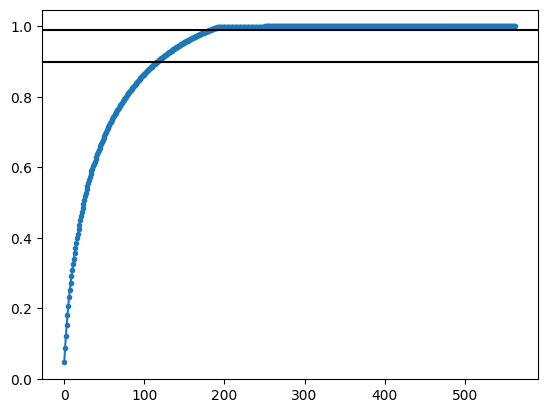

In [ ]:
pca = PCA()
pca.fit(X_train_var2, y_train_smote)
explained = pd.Series(pca.explained_variance_ratio_, name='Explained Variance Ratio')
ax = explained.cumsum().plot(marker='.')
ax.axhline(.9, color='k');
ax.axhline(.99, color='k');

* There is an elbow at explained vareince = 0.99 , and I see that is a very good variance , in addition it is explained with a small no of pca's acomparing to the actual features count  .

In [ ]:
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_var2)
X_test_pca = pca.transform(X_test_var2)
# obtain the number of PCs used
pca.n_components_

np.int64(183)

##Keras

In [ ]:
input_shape=X_train_pca.shape[1]
input_shape

183

####Baseline model

In [ ]:
model=Sequential()
model.add(Dense(input_shape, input_dim = input_shape,activation='relu'))
model.add(Dense(50, input_dim = input_shape,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history=model.fit(X_train_pca,y_train_smote,epochs=50,batch_size=32,validation_split=0.2)

Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6652 - loss: 35.8670 - val_accuracy: 0.6874 - val_loss: 15.0283
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7173 - loss: 7.1490 - val_accuracy: 0.7056 - val_loss: 6.8607
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7257 - loss: 2.1665 - val_accuracy: 0.7272 - val_loss: 5.1110
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7711 - loss: 1.2525 - val_accuracy: 0.6977 - val_loss: 2.4964
Epoch 5/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7695 - loss: 0.7001 - val_accuracy: 0.7498 - val_loss: 2.1476
Epoch 6/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7944 - loss: 0.4811 - val_accuracy: 0.7414 - val_loss: 2.0287
Epoch 7/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7956 - loss: 0.4653 - val_accuracy: 0.7483 - val_loss: 1.9980
Epoch 8/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8057 - loss: 0.4252 - val_accuracy: 

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 183)            │        33,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         9,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,771 (503.02 KB)

 Trainable params: 42,923 (167.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,848 (335.35 KB)

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>], dtype=object))

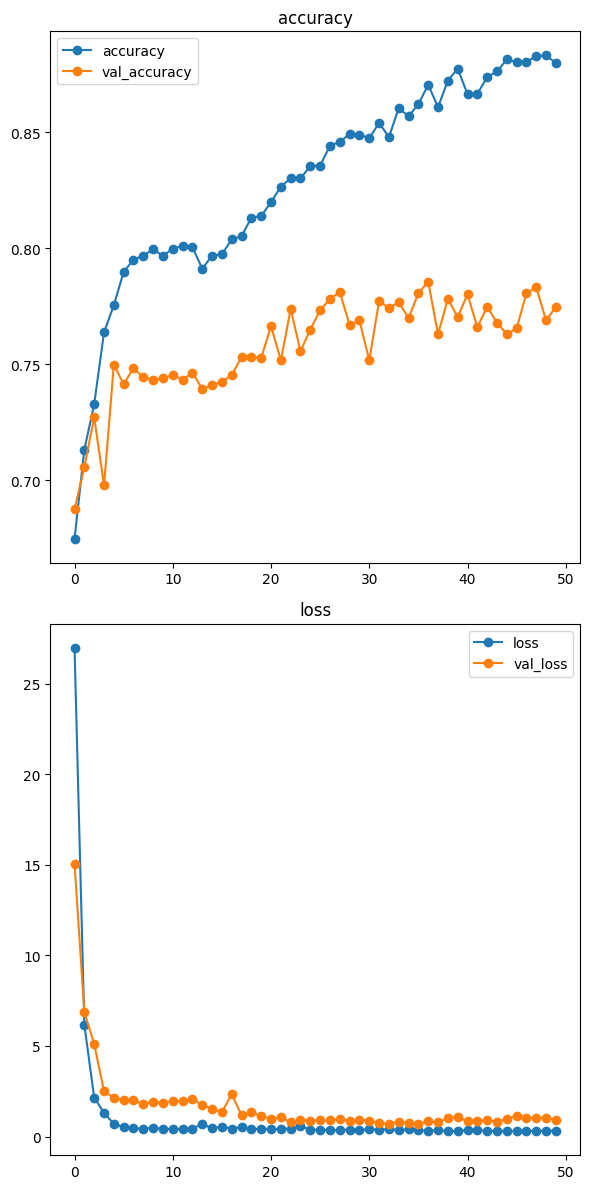

In [ ]:
plot_history(history)

* The model didnt completly converge , so i willo increase the no of epochs

In [ ]:
history=model.fit(X_train_pca,y_train_smote,epochs=70,batch_size=32,validation_split=0.2)

Epoch 1/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8840 - loss: 0.2836 - val_accuracy: 0.7723 - val_loss: 0.8739
Epoch 2/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8887 - loss: 0.2976 - val_accuracy: 0.7738 - val_loss: 0.7614
Epoch 3/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8778 - loss: 0.3036 - val_accuracy: 0.7758 - val_loss: 0.9669
Epoch 4/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8910 - loss: 0.2722 - val_accuracy: 0.7694 - val_loss: 1.1199
Epoch 5/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8933 - loss: 0.2771 - val_accuracy: 0.7645 - val_loss: 1.1895
Epoch 6/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9054 - loss: 0.2443 - val_accuracy: 0.7650 - val_loss: 1.4949
Epoch 7/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8886 - loss: 0.3320 - val_accuracy: 0.7807 - val_loss: 1.0146
Epoch 8/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9038 - loss: 0.2627 - val_accuracy: 0

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 183)            │        33,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         9,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,771 (503.02 KB)

 Trainable params: 42,923 (167.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,848 (335.35 KB)

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>], dtype=object))

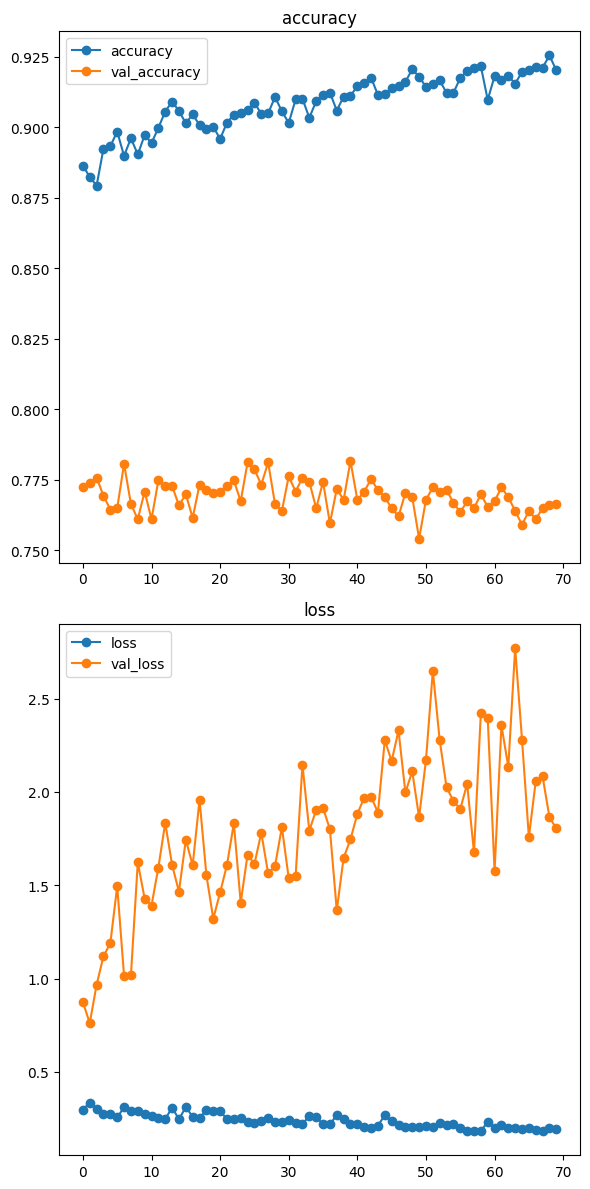

In [ ]:
plot_history(history)

* There is an overfitting , so i willl add a dropout layer

#### With dropout

In [ ]:
model2=Sequential()
model2.add(Dense(input_shape, input_dim = input_shape,activation='relu'))
model2.add(Dense(50, input_dim = input_shape,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model2.fit(X_train_pca,y_train_smote,epochs=70,batch_size=32,validation_split=0.2)

Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6439 - loss: 61.8379 - val_accuracy: 0.7306 - val_loss: 7.4881
Epoch 2/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7311 - loss: 4.1603 - val_accuracy: 0.7296 - val_loss: 1.8098
Epoch 3/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7502 - loss: 1.1207 - val_accuracy: 0.7542 - val_loss: 0.9666
Epoch 4/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7568 - loss: 0.6247 - val_accuracy: 0.7566 - val_loss: 0.8964
Epoch 5/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7702 - loss: 0.6181 - val_accuracy: 0.7571 - val_loss: 0.7231
Epoch 6/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7660 - loss: 0.5806 - val_accuracy: 0.7586 - val_loss: 0.7151
Epoch 7/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7654 - loss: 0.5379 - val_accuracy: 0.7522 - val_loss: 0.7126
Epoch 8/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7636 - loss: 0.5555 - val_accuracy: 0.7596 - val

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 183)            │        33,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         9,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,771 (503.02 KB)

 Trainable params: 42,923 (167.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,848 (335.35 KB)

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>], dtype=object))

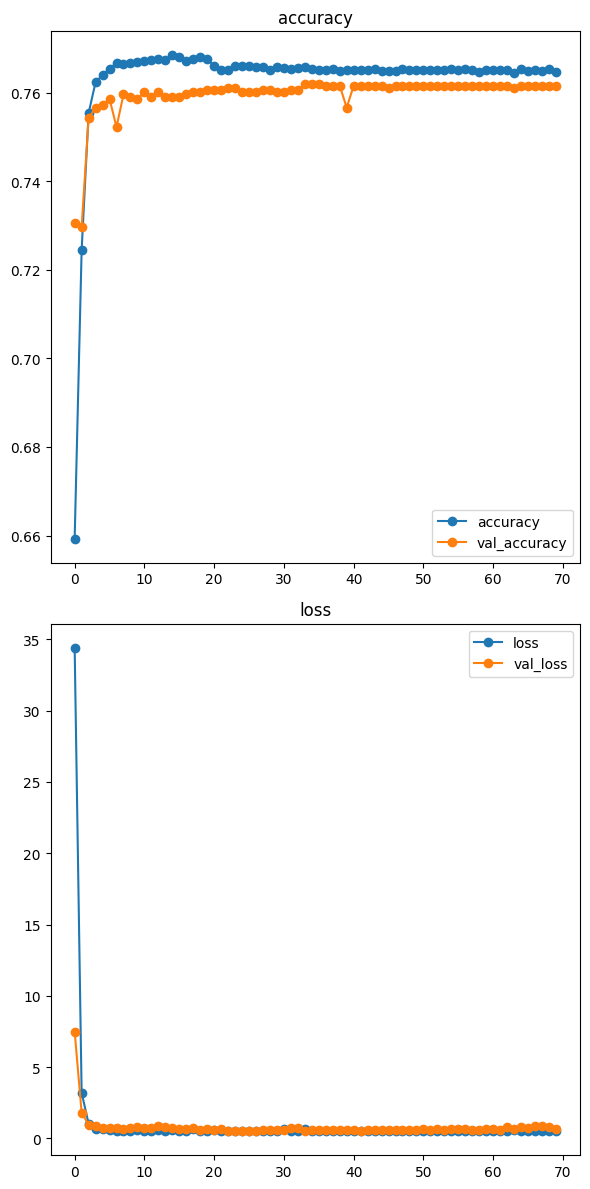

In [ ]:
plot_history(history)

* The model did converge now
* and the loss that the plot convarge at , is convencing

#### Model tunning

In [ ]:
def build_model(hp):
    model3=Sequential()
    model3.add(Dense(input_shape, input_dim = input_shape,activation='relu'))
    model3.add(Dense(units=hp.Int('units', min_value=50, max_value=100, step=5), activation='relu'))
    model3.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    model3.add(Dense(1, activation='sigmoid'))
    model3.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',

                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    # history=model2.fit(X_train_pca,y_train_smote,epochs=70,batch_size=32,validation_split=0.2)
    return model3

In [ ]:

import os
folder = '/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/05-IntermediateML/Week20/KerasTuner/'
os.makedirs(folder, exist_ok=True)


In [ ]:
# Define tuner object
tuner = kt.Hyperband(build_model,

                     objective='val_accuracy',# use recall / F1 score better that accuracy
                     max_epochs=100,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='student success tuner')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = EarlyStopping(patience = 5)
tuner.search(X_train_pca,y_train_smote,  epochs=70,
             validation_split=0.2, callbacks = [early_stopping])

Trial 223 Complete [00h 00m 21s]
val_accuracy: 0.7615309357643127

Best val_accuracy So Far: 0.7968596816062927
Total elapsed time: 00h 40m 31s


In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values


{'units': 60,
 'dropout_value': 0.30000000000000004,
 'optimizer': 'nadam',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0204'}

In [ ]:
best_model = tuner.get_best_models()[0]
best_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 15 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 183)            │        33,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        11,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,773 (174.89 KB)

 Trainable params: 44,773 (174.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=best_model.fit(X_train_pca,y_train_smote,epochs=70,batch_size=32,validation_split=0.2)

Epoch 1/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8321 - loss: 0.4318 - precision: 0.8365 - recall: 0.9727 - val_accuracy: 0.7846 - val_loss: 0.6870 - val_precision: 0.8164 - val_recall: 0.9253
Epoch 2/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8360 - loss: 0.4986 - precision: 0.8371 - recall: 0.9762 - val_accuracy: 0.7934 - val_loss: 0.7224 - val_precision: 0.8068 - val_recall: 0.9581
Epoch 3/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8365 - loss: 0.4270 - precision: 0.8384 - recall: 0.9742 - val_accuracy: 0.7836 - val_loss: 0.7483 - val_precision: 0.7931 - val_recall: 0.9684
Epoch 4/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8258 - loss: 0.4299 - precision: 0.8251 - recall: 0.9793 - val_accuracy: 0.7890 - val_loss: 0.7194 - val_precision: 0.8169 - val_recall: 0.9317
Epoch 5/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8520 - loss: 0.3827 - precision: 0.8514 - recall: 0.9783 - val_accuracy: 0.7866 - val_loss: 0.

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'recall'}>], dtype=object))

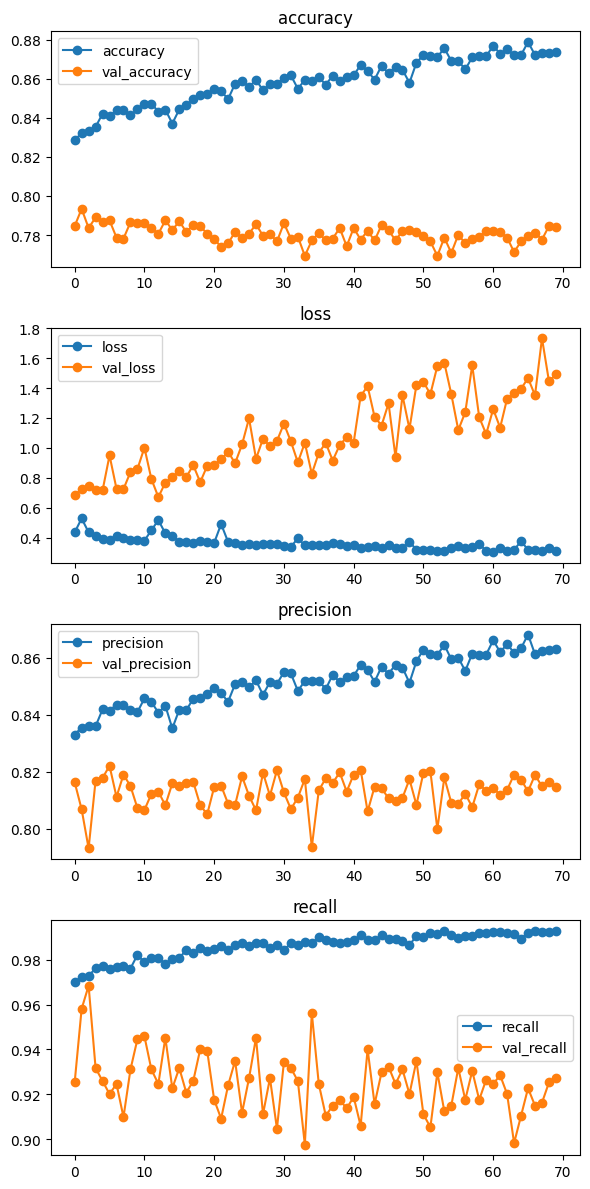

In [ ]:
plot_history(history)

The loss seems to start decreasing at 70 epochs , so i will increase the no of epochs

In [ ]:
folder2 = '/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/05-IntermediateML/Week20/KerasTuner2/'
os.makedirs(folder2, exist_ok=True)

In [ ]:
tuner = kt.Hyperband(build_model,
## use recall / F1 score better that accuracy
                     objective='val_loss',
                     max_epochs=100,
                     directory=folder2,
                     overwrite = True,
                     seed = 42,
                     project_name='student success tuner')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stopping = EarlyStopping(patience = 5)
tuner.search(X_train_pca,y_train_smote,  epochs=100,
             validation_split=0.2, callbacks = [early_stopping])

Trial 223 Complete [00h 00m 24s]
val_loss: 0.8929473757743835

Best val_loss So Far: 0.5323231220245361
Total elapsed time: 00h 53m 35s


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 183)            │        33,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │        14,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,473 (189.35 KB)

 Trainable params: 48,473 (189.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=best_model.fit(X_train_pca,y_train_smote,epochs=70,batch_size=32,validation_split=0.2)

Epoch 1/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8020 - loss: 0.4939 - precision: 0.8083 - recall: 0.9704 - val_accuracy: 0.7807 - val_loss: 0.6843 - val_precision: 0.7844 - val_recall: 0.9820
Epoch 2/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8054 - loss: 0.5114 - precision: 0.8079 - recall: 0.9764 - val_accuracy: 0.7826 - val_loss: 0.5714 - val_precision: 0.8058 - val_recall: 0.9414
Epoch 3/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8085 - loss: 0.5039 - precision: 0.8142 - recall: 0.9704 - val_accuracy: 0.7900 - val_loss: 0.5624 - val_precision: 0.7989 - val_recall: 0.9678
Epoch 4/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8156 - loss: 0.5963 - precision: 0.8172 - recall: 0.9762 - val_accuracy: 0.7949 - val_loss: 0.6852 - val_precision: 0.8032 - val_recall: 0.9678
Epoch 5/70
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8188 - loss: 0.4732 - precision: 0.8177 - recall: 0.9817 - val_accuracy: 0.7821 - val_loss: 0.

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'recall'}>], dtype=object))

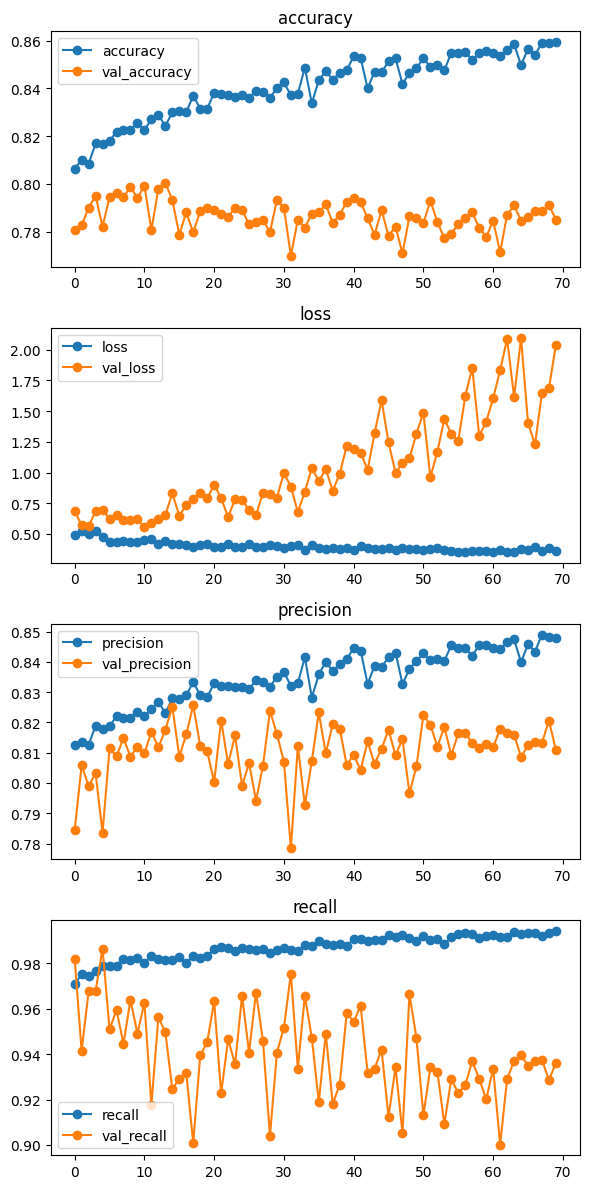

In [ ]:
plot_history(history)

This is the worst model ever hhhhh
* The model didnt converge
* There is overfitting

###Evaluation on test data

* Model 2 is the best model among other models :
  * It converge
  * There is no overfitting\underfitting
  * Th loss is convencing

In [ ]:
# Evaluate neural network with builtin evaluation
result = model2.evaluate(X_test_pca, y_test,return_dict=True)
result

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7733 - loss: 0.7319


{'accuracy': 0.7582417726516724, 'loss': 0.9043294787406921}

In [ ]:
# make predictions
y_pred_test = model.predict(X_test_pca)
y_pred_test[:5]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.9952338 ],
       [0.7379744 ],
       [0.9702751 ],
       [0.6387672 ],
       [0.99963754]], dtype=float32)

In [ ]:
# round the predictions
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.57      0.39      0.47       616
           1       0.82      0.91      0.86      1932

    accuracy                           0.78      2548
   macro avg       0.70      0.65      0.66      2548
weighted avg       0.76      0.78      0.77      2548



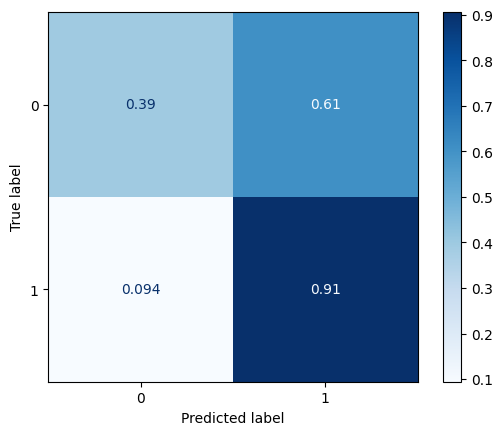

In [ ]:
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');

* The model is excellent in finding the studennts who pass
* But quit poor in detecting the students who fail,it misses almost 70% of student who failed